In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [14]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 20.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import gc

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras import metrics
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate

import torch
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)

import seaborn as sns

import nltk
nltk.download('stopwords')
import math

import torch

from smart_open import open
from nltk.corpus import stopwords
import sklearn
from sklearn.metrics import classification_report
from keras.layers import Dropout
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from gensim.models.keyedvectors import KeyedVectors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
dev_df = pd.read_csv('/content/drive/My Drive/diacwoz/dev_split_Depression_AVEC2017.csv',delimiter=',',encoding='utf-8')
test_df = pd.read_csv('/content/drive/My Drive/diacwoz/full_test_split.csv',delimiter=',',encoding='utf-8')
train_df = pd.read_csv('/content/drive/My Drive/diacwoz/train_split_Depression_AVEC2017.csv',delimiter=',',encoding='utf-8')

train_combined_df = pd.concat([dev_df, train_df], ignore_index=True)
train_combined_df

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,302,0,4,1,1,1,0.0,1,0,1,0,0
1,307,0,4,0,0,1,0.0,1,0,2,0,0
2,331,0,8,1,1,1,1.0,1,1,1,1,1
3,335,1,12,0,1,1,3.0,2,3,1,1,0
4,346,1,23,0,2,3,3.0,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
137,485,0,2,1,0,1,0.0,0,0,0,0,1
138,486,0,4,0,1,1,0.0,1,0,1,0,0
139,487,0,0,0,0,0,0.0,0,0,0,0,0
140,488,0,0,0,0,0,0.0,0,0,0,0,0


In [20]:
# Data set has identical distribution based on gender
plot_df = train_combined_df.copy()

plot_df['Gender'] = plot_df['Gender'].replace({0: 'male', 1: 'female'})
plot_df['PHQ8_Binary'] = plot_df['PHQ8_Binary'].replace({0: 'Not depressed', 1: 'depressed'})

plot_df['Gender'] = plot_df['Gender'].astype('category')
plot_df['PHQ8_Binary'] = plot_df['PHQ8_Binary'].astype('category')
plot_df.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,302,Not depressed,4,female,1,1,0.0,1,0,1,0,0
1,307,Not depressed,4,male,0,1,0.0,1,0,2,0,0
2,331,Not depressed,8,female,1,1,1.0,1,1,1,1,1
3,335,depressed,12,male,1,1,3.0,2,3,1,1,0
4,346,depressed,23,male,2,3,3.0,3,3,3,3,3


<Axes: xlabel='Gender'>

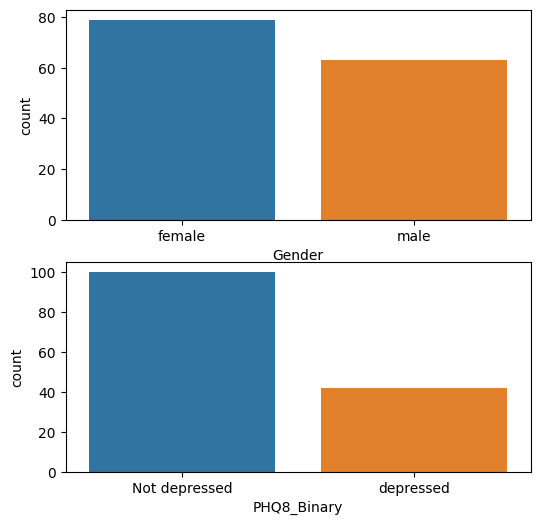

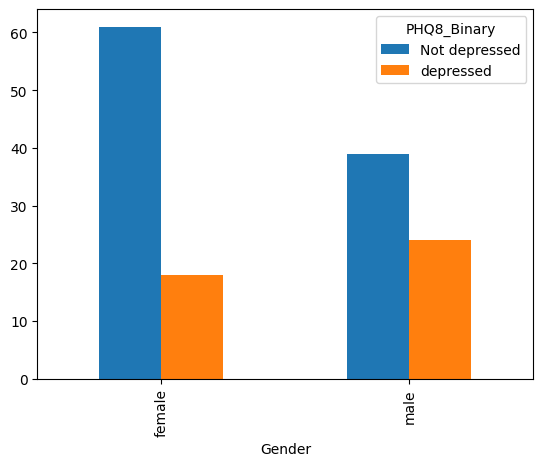

In [21]:
temp_df = pd.crosstab(index=plot_df['Gender'],columns=plot_df['PHQ8_Binary'])

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))
sns.countplot(data=plot_df, x='Gender', ax=axes[0])
sns.countplot(data=plot_df, x='PHQ8_Binary', ax=axes[1])

temp_df.plot.bar()

In [22]:
devData = np.array(dev_df)[:,0:2]
trainData = np.array(train_df)[:,0:2]
testData = np.array(test_df)[:,0:2]

# Xtrain = []
Ytrain = []
# Xtest = []
Ytest = []

audio_train = []
video_train = []
text_train = []

audio_test = []
video_test = []
text_test = []

MAX_NUM_WORDS=17
NUM_SENTENCES = 250
PATH_TO_DEV = r'/content/drive/My Drive/diacwoz/dev_data'
PATH_TO_TEST = r'/content/drive/My Drive/diacwoz/test_data'
PATH_TO_TRAIN = r'/content/drive/My Drive/diacwoz/train_data'
stop_words = set(stopwords.words('english'))

In [23]:
import os.path

dataset = np.concatenate((devData, np.concatenate((testData, trainData))))
def checkDataPointExistence(patientID, split):
    for i in split:
        if(patientID == i[0]):
            return True
    return False

def remove_StopWords(sentence):
    filtered_sentence = [] 
    for w in sentence: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    return filtered_sentence

def returnWordToVec(sentence):
    global max_num_words, stop_words, model
    sentence = str(sentence).split(" ")
    sentence = remove_StopWords(sentence)
    index_word = 0
    wordMatrix = np.zeros(MAX_NUM_WORDS*300)
    for j in range(min(MAX_NUM_WORDS, len(sentence))):
        try:
            word = sentence[j]
            if(word[0] == '<'):
                if(word.find('>')!=-1):
                    word = word[1:-1]
                else:
                    word = word[1:]
            else:
                if(word.find('>')!=-1):
                    word = word[0:-1]
                    ss = np.array(model[word])
                    wordMatrix[index_word*300:(index_word+1)*300] = ss
                    index_word+=1
        except Exception as e:
            continue
    wordMatrix = np.array(wordMatrix.reshape(1,-1))
    return wordMatrix

def getTextData(patientID, location):
    fileName = str(location) + "/" + str(int(patientID)) + "_TRANSCRIPT.csv"        
    file = np.array(pd.read_csv(fileName,delimiter='\t',encoding='utf-8', engine='python'))
    participant_answers = []
        
    # Remove All Utterences By Ellie:
    for i in range(len(file)):
        if(file[i][2] == 'Participant'):
            participant_answers.append(file[i])

    participant_answers = np.array(participant_answers)  
    #print(participant_answers)

    # Remove Speaker Columnn
    participant_answers = np.delete(participant_answers, 2, 1)
    
    # Convert Text Into Word Vectors:
    w2vs = np.zeros((1, MAX_NUM_WORDS *300))
    for i in range(len(participant_answers)):
        sentence = participant_answers[i][2]
        w2v = returnWordToVec(sentence)
        w2vs = np.concatenate((w2vs, w2v), axis = 0)
    w2vs = np.delete(w2vs, 0, 0)
    #print(len(w2vs))

    # Delete Sentences and Replace With W2Vs
    participant_answers = np.delete(participant_answers, 2, 1)
    participant_answers = np.concatenate((participant_answers, w2vs), axis = 1)
    return participant_answers

def refactor(arr, size):
    arrsize = arr.shape[0]
    temp = np.zeros((size, arr.shape[1]))
    for i in range(min(len(arr), size)):
        temp[i] = arr[i]
    return temp

def getData(patientID, location):
    text_data = getTextData(patientID, location)
    return text_data

In [10]:
for datapoint in dataset:
    if(checkDataPointExistence(datapoint[0], devData)):
        file_name = str(PATH_TO_DEV) + "/" + str(int(datapoint[0])) + "_TRANSCRIPT.csv"
        if not os.path.isfile(file_name):
            continue
    
        text = getData(datapoint[0], PATH_TO_DEV)
        text_train.append(text)
        Ytrain.append(datapoint[1])
    if(checkDataPointExistence(datapoint[0], testData)):
        file_name = str(PATH_TO_TEST) + "/" + str(int(datapoint[0])) + "_TRANSCRIPT.csv"
        if not os.path.isfile(file_name):
            continue
    
        text = getData(datapoint[0], PATH_TO_TEST)
        text_test.append(text)
        Ytest.append(datapoint[1])
    if(checkDataPointExistence(datapoint[0], trainData)):
        file_name = str(PATH_TO_TRAIN) + "/" + str(int(datapoint[0])) + "_TRANSCRIPT.csv"
        if not os.path.isfile(file_name):
            continue
    
        text = getData(datapoint[0], PATH_TO_TRAIN)
        text_train.append(text)
        Ytrain.append(datapoint[1])


Preapre test and train data

In [ ]:
for i in range(len(text_train)):
    text_train[i] = refactor(text_train[i], NUM_SENTENCES)

for i in range(len(text_test)):
    text_test[i] = refactor(text_test[i], NUM_SENTENCES)

text_test = np.array(text_test)
text_train = np.array(text_train)

print(text_train.shape)

In [ ]:
text_test = text_test[:,:,2:]
text_train = text_train[:,:,2:]

import sklearn
from sklearn import preprocessing

Ytrain = np.array(Ytrain)
Ytest = np.array(Ytest)

def upsample(X_train,Y_train):
    X_train_0 = X_train[Y_train==0]
    X_train_1 = X_train[Y_train==1]

    Y_train_1 = Y_train[Y_train==1]
    # print(Y_train_1.shape)
    # print(X_train_1.shape)
    size = X_train_0.shape[0] - X_train_1.shape[0]
    X = []
    Y = []
    X_train = list(X_train)
    Y_train = list(Y_train)
    while(size>0):
        size -= 1
        index = np.random.randint(0,X_train_1.shape[0]-1)
        leave_index = np.random.randint(0,len(X_train)-1)
        X_add = X_train_1[index]
        X_leave = X_train[leave_index]

        Y_add = Y_train_1[index]
        Y_leave = Y_train[leave_index]

        X_train[leave_index] = X_add
        X_train.append(X_leave)

        Y_train[leave_index] = Y_add
        Y_train.append(Y_leave)
    
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    return X_train,Y_train

text_train = np.nan_to_num(text_train)
text_train, Ytrain = upsample(text_train,Ytrain)

print(text_train.shape)
print(Ytrain.shape)

for i in range(text_train.shape[0]):
    text_train[i] = sklearn.preprocessing.normalize(text_train[i])

print(Ytest.shape)
text_test = np.nan_to_num(text_test)

for i in range(text_test.shape[0]):
    text_test[i] = sklearn.preprocessing.normalize(text_test[i])

In [ ]:
model = Sequential([Input(shape = (250,5100), name = 'Text_input'),
                   Dense(1000, activation=tf.nn.relu),
                   Dense(500, activation=tf.nn.relu),
                   Dense(250, activation=tf.nn.softmax),
                   Dense(74, activation=tf.nn.softmax),
                   LSTM(128, dropout = 0.2, recurrent_dropout = 0.2),
                   Dense(1, activation='sigmoid')])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.0004),
             loss='binary_crossentropy')
history = model.fit([text_train], Ytrain, validation_split = 0.2, callbacks = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='min',
        baseline=None, restore_best_weights=True),epochs=50, batch_size = 10)

Epoch 1/50
16/16 [==============================] - 38s 2s/step - loss: 0.6953 - val_loss: 0.6981
Epoch 2/50
16/16 [==============================] - 32s 2s/step - loss: 0.6928 - val_loss: 0.6964
Epoch 3/50


In [ ]:
print(text_test.shape)

In [ ]:
pred = model.predict([text_test])
print(pred)
y_pred = [int(score >= 0.5) for score in pred]

from sklearn.metrics import classification_report
print(classification_report(Ytest,y_pred))

2/2 [==============================] - 3s 714ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        33
         1.0       0.30      1.00      0.46        14

    accuracy                           0.30        47
   macro avg       0.15      0.50      0.23        47
weighted avg       0.09      0.30      0.14        47



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
text_train_transformer = []
text_test_transformer = []
y_train_transformer = []
y_test_transformer = []

In [ ]:
def get_participant_text(patientID, location):
    fileName = str(location) + "/" + str(int(patientID)) + "_TRANSCRIPT.csv"        
    file = np.array(pd.read_csv(fileName,delimiter='\t',encoding='utf-8', engine='python'))
    participant_answers = []
        
    # Remove All Utterences By Ellie:
    for i in range(len(file)):
        if(file[i][2] == 'Participant'):
            participant_answers.append(file[i])

    participant_answers = np.array(participant_answers)  
    #print(participant_answers)
    # Remove Speaker Columnn
    participant_answers = np.delete(participant_answers, [0,1,2], 1)
    
    text = ""
    for conversation in participant_answers:
        #print(type(conversation))
        text += str(conversation[0])
    return text

def get_data_for_transformer(patientID, location):
    text_data_tranf = get_participant_text(patientID, location)
    #print(text_data_tranf)
    return text_data_tranf

for datapoint in dataset:
    if(checkDataPointExistence(datapoint[0], devData)):
        file_name = str(PATH_TO_DEV) + "/" + str(int(datapoint[0])) + "_TRANSCRIPT.csv"
        if not os.path.isfile(file_name):
            continue
        text_train_transformer.append(get_data_for_transformer(datapoint[0], PATH_TO_DEV))
        y_train_transformer.append(float(datapoint[1]))
    if(checkDataPointExistence(datapoint[0], testData)):
        file_name = str(PATH_TO_TEST) + "/" + str(int(datapoint[0])) + "_TRANSCRIPT.csv"
        if not os.path.isfile(file_name):
            continue
        text_test_transformer.append(get_data_for_transformer(datapoint[0], PATH_TO_TEST))
        y_test_transformer.append(float(datapoint[1]))
    if(checkDataPointExistence(datapoint[0], trainData)):
        file_name = str(PATH_TO_TRAIN) + "/" + str(int(datapoint[0])) + "_TRANSCRIPT.csv"
        if not os.path.isfile(file_name):
            continue
        text_train_transformer.append(get_data_for_transformer(datapoint[0], PATH_TO_TRAIN))
        y_train_transformer.append(float(datapoint[1]))

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
x_train_encoded = tokenizer(text_train_transformer, padding=True, truncation=True, return_tensors="pt")
x_test_encoded = tokenizer(text_test_transformer, padding=True, truncation=True, return_tensors="pt")

In [ ]:
print(x_train_encoded)

x_train_enc_2 = dict()
for key, value in x_train_encoded.items():
    x_train_enc_2[key] = value[0:512]

x_test_enc_2 = dict()
for key, value in x_test_encoded.items():
    x_test_enc_2[key] = value[0:512]

{'input_ids': tensor([[  101,   178,   112,  ...,  2450, 23698,   102],
        [  101,   133,  7053,  ...,  1106,  1103,   102],
        [  101,  4208,  3008,  ...,  3055,  1427,   102],
        ...,
        [  101,   133,   188,  ...,  1930,  1474,   102],
        [  101,   133,   188,  ...,  1139,  2104,   102],
        [  101,   133,   188,  ...,  1184,  1103,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}


In [ ]:
from sklearn.model_selection import train_test_split

(train_inputs, 
 validation_inputs,
 train_labels, 
 validation_labels) = train_test_split(np.array(x_train_enc_2['input_ids']), y_train_transformer,
                                                     random_state=42,
                                                     test_size=0.1)
(train_masks, 
 validation_masks,
 _, _) = train_test_split(x_train_enc_2['attention_mask'], y_train_transformer,
                          random_state=42, test_size=0.1)
 
train_inputs = train_inputs.clone().detach()
train_labels = torch.tensor(train_labels)
train_masks  = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks  = torch.tensor(validation_masks)
test_inputs = torch.tensor(x_test_enc_2['input_ids'])
test_labels = torch.tensor(y_test_transformer)
test_masks  = torch.tensor(x_test_enc_2['attention_mask'])

<ipython-input-45-1045708b9e07>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_masks  = torch.tensor(train_masks)
<ipython-input-45-1045708b9e07>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_masks  = torch.tensor(validation_masks)
<ipython-input-45-1045708b9e07>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(x_test_enc_2['input_ids'])
<ipython-input-45-1045708b9e07>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor

In [ ]:
BATCH_SIZE = 1

print('Train: ', end="")
train_data = TensorDataset(train_inputs, train_masks,
                           train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=BATCH_SIZE)
print(len(train_data), 'messages')

print('Validation: ', end="")
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=BATCH_SIZE)
print(len(validation_data), 'messages')

print('Test: ', end="")
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler,
                             batch_size=BATCH_SIZE)
print(len(test_data), 'messages')

Train: 127 messages
Validation: 15 messages
Test: 47 messages


In [ ]:
from transformers import BertForSequenceClassification
from transformers import AdamW

# ## BERT model initialization
#
# We now load a pretrained BERT model with a single linear
# classification layer added on top.

print('Initializing BertForSequenceClassification')

model = BertForSequenceClassification.from_pretrained("bert-base-cased",
                                                      cache_dir=".",
                                                      num_labels=1)

# We set the remaining hyperparameters needed for fine-tuning the
# pretrained model:
#   * EPOCHS: the number of training epochs in fine-tuning
#     (recommended values between 2 and 4)
#   * WEIGHT_DECAY: weight decay for the Adam optimizer
#   * LR: learning rate for the Adam optimizer (2e-5 to 5e-5 recommended)
#   * WARMUP_STEPS: number of warmup steps to (linearly) reach the set
#     learning rate
#
# We also need to grab the training parameters from the pretrained model.

EPOCHS = 4
WEIGHT_DECAY = 0.01
LR = 2e-5
WARMUP_STEPS =int(0.2*len(train_dataloader))

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY},
    {'params': [p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=WARMUP_STEPS,
#                                 t_total=len(train_dataloader)*EPOCHS)

Initializing BertForSequenceClassification


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
# ## Learning
#
# Let's now define functions to train() and evaluate() the model:
device = torch.device('cpu')

def train(epoch, loss_vector=None, log_interval=200):
  # Set model to training mode
  model.train()

  # Loop over each batch from the training set
  for step, batch in enumerate(train_dataloader):

    # Copy data to GPU if needed
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Zero gradient buffers
    optimizer.zero_grad()

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask, labels=b_labels)

    loss = outputs[0]
    if loss_vector is not None:
        loss_vector.append(loss.item())

    # Backward pass
    loss.backward()

    # Update weights
    #scheduler.step()
    optimizer.step()

    if step % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(b_input_ids),
                len(train_dataloader.dataset),
                100. * step / len(train_dataloader), loss))

def evaluate(loader):
    model.eval()
    n_correct, n_all = 0, 0
    
    for batch in loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
        logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)

    labels = b_labels.to('cpu').numpy()
    n_correct += np.sum(predictions == labels)
    n_all += len(labels)
    
    print('Accuracy: [{}/{}] {:.4f}\n'.format(n_correct,
                                            n_all,
                                            n_correct/n_all))

# Now we are ready to train our model using the train()
# function. After each epoch, we evaluate the model using the
# validation set and evaluate().

train_lossv = []
for epoch in range(1, EPOCHS + 1):
    train(epoch, train_lossv)
    print('\nValidation set:')
    evaluate(validation_dataloader)

Train Epoch: 1 [0/127 (0%)]	Loss: 0.022764

Validation set:
Accuracy: [1/1] 1.0000

Train Epoch: 2 [0/127 (0%)]	Loss: 0.265454

Validation set:
Accuracy: [1/1] 1.0000

Train Epoch: 3 [0/127 (0%)]	Loss: 0.040365

Validation set:
Accuracy: [1/1] 1.0000

Train Epoch: 4 [0/127 (0%)]	Loss: 0.130244

Validation set:
Accuracy: [1/1] 1.0000



In [ ]:
print('Test set:')
evaluate(test_dataloader)

Test set:
Accuracy: [1/1] 1.0000

